<a href="https://colab.research.google.com/github/zachwooding/GIMM400Utilities/blob/master/TidePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install serial
!pip install pyfirmata
!pip install git+git://github.com/fchollet/keras.git --upgrade --no-deps

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package serial
  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-q80ubiw6
  Running command git clone -q git://github.com/fchollet/keras.git /tmp/pip-req-build-q80ubiw6
  Created wheel for Keras: filename=Keras-2.3.1-cp36-none-any.whl size=365121 sha256=a08141f84b9b0fbd1c02461e52c6ed21816bd4a7f2850e02ea12f5b069f57e2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9v4315v/wheels/dc/a7/a2/8b2d0fd23dee9c609b4c95f2b5ed27997ed17ccbeabbebfc64
Successfully built Keras
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import csv 
import requests 
import xml.etree.ElementTree as ET 
import serial
import random
import pandas as pd
import datetime


def loadXMLFile():
  from google.colab import files
  uploaded = files.upload()
  print(uploaded)
  return uploaded

def parseXML():
  files = ['Jan.xml', 'Feb.xml', 'Mar.xml', 'Apr.xml', 'May.xml', 'Jun.xml', 'Jul.xml', 'Aug.xml', 'Sep.xml', 'Oct.xml', 'Nov.xml', 'Dec.xml']
  dictList = []
  for f in files:
    tree = ET.parse(f)
    root = tree.getroot()
    for data in root.findall('data'):
      
      for item in data.findall('item'):
        tide = {}
        
        for x in item:
          
          tide[x.tag] = x.text
        dictList.append(tide)
  return dictList

      
      

def readArduino():
  arduino = serial.Serial('COM1', 115200, timeout=.1)
  while True:
    data = arduino.readline()
    if data:
      parseData = data.split()
      i = 0
      for d in parseData:
        if(d == "Date:"):
          date = parseData[i + 1]
        if(d == "Time:"):
          time = parseData[i + 1]
        if(d == "Lat:"):
          lat = parseData[i + 1]
        if(d == "Long:"):
          long = parseData[i + 1]
        if(d == "Speed:"):
          speed = parseData[i + 1]
        if(d == "Direction:"):
          direction = parseData[i + 1]
        i += 1
        
def setWind(tides):
  windDir = ['e','ne','se','w','nw','sw','n','s']
  dictList = []
  lastDate = ""
  for t in tides:
    curDate = t["date"]
    if lastDate != curDate:
      wind = {}
      wind["date"] = curDate
      wind["direction"] = windDir[random.randrange(0,7)]
      wind["speed"] = random.randrange(0,35)
      dictList.append(wind)
      lastDate = curDate
      
    
  return dictList

def setPres(tides):
  orgin = random.uniform(950.0,1050.0)
  dictList = []
  lastDate = ""
  i = 0
  for t in tides:
    curDate = t["date"]
    if lastDate != curDate:
      pres = {}
      pres["date"] = curDate
      if i == 0:
        pres["pressure"] = float("{:.2f}".format(orgin))
        pres["change"] = 0
        i += 1
      else:
        last = dictList[i-1]
        change = random.uniform(-20.0,20.0)
        pres["pressure"] = float("{:.2f}".format(float(last["pressure"]) + change))
        pres["change"] = float("{:.2f}".format(change))
        
      dictList.append(pres)
      lastDate = curDate
    

      
  return dictList
  



tideData = parseXML()
windData = setWind(tideData)
presData = setPres(tideData)
print("Tides: " +  str(len(tideData)))
print("Wind: " + str(len(windData)))
print("Pressure: " + str(len(presData)))
print(tideData)
print(windData)
print(presData)
  

Tides: 1414
Wind: 366
Pressure: 366
[{'date': '2020/01/01', 'day': 'Wed', 'time': '04:35', 'pred': '2.20', 'highlow': 'H'}, {'date': '2020/01/01', 'day': 'Wed', 'time': '10:59', 'pred': '0.63', 'highlow': 'L'}, {'date': '2020/01/01', 'day': 'Wed', 'time': '17:33', 'pred': '3.59', 'highlow': 'H'}, {'date': '2020/01/02', 'day': 'Thu', 'time': '00:19', 'pred': '0.98', 'highlow': 'L'}, {'date': '2020/01/02', 'day': 'Thu', 'time': '05:38', 'pred': '2.23', 'highlow': 'H'}, {'date': '2020/01/02', 'day': 'Thu', 'time': '11:46', 'pred': '0.95', 'highlow': 'L'}, {'date': '2020/01/02', 'day': 'Thu', 'time': '18:02', 'pred': '3.43', 'highlow': 'H'}, {'date': '2020/01/03', 'day': 'Fri', 'time': '01:01', 'pred': '0.80', 'highlow': 'L'}, {'date': '2020/01/03', 'day': 'Fri', 'time': '06:40', 'pred': '2.32', 'highlow': 'H'}, {'date': '2020/01/03', 'day': 'Fri', 'time': '12:37', 'pred': '1.26', 'highlow': 'L'}, {'date': '2020/01/03', 'day': 'Fri', 'time': '18:28', 'pred': '3.29', 'highlow': 'H'}, {'date

In [0]:
def processData(tides, winds, pressure):
  avgPres = 1013.25
  i=0
  for tide in tides:
    wind = winds[i]
    pres = pressure[i]
    if wind["date"] != tide["date"]:
      wind = winds[i]
      pres = pressure[i]
    rawTide = float(tide["pred"])
    air = editPred(wind, tide, pres)
    editedTide = rawTide + air
    curStr = tide["current"].split(':')
    curTime = [int(curStr[0]), int(curStr[1])]
    curTime[1] += air * 5
    
    while curTime[1] > 59:
      curTime[0] += 1
      curTime[1] = curTime[1] - 60
    while curTime[1] < 0:
      curTime[0] -= 1
      curTime[1] = 60 + curTime[1]
    
    tide["current"] = "{:0>2d}".format(int(curTime[0])) + ":"+"{:0>2d}".format(int(curTime[1]))
    timeDiff = calcTimeDiff(tide["date"], tide["time"], tide["current"])
    tide["current_diff"] = timeDiff

    if tide["highlow"] == 'H':
      tide["highlow"] = 1
    elif tide["highlow"] == 'L':
      tide["highlow"] = 0
  return tides


def calcTimeDiff(date, tide, current):
  dateSplit = date.split('/')
  tideTime = tide.split(':')
  curTime = current.split(':')
  nums =[]
  nums.append(dateSplit[0])
  nums.append(dateSplit[1])
  nums.append(dateSplit[2])
  nums.append(tideTime[0])
  nums.append(tideTime[1])
  nums.append(curTime[0])
  nums.append(curTime[1])
  i = 0
  
  
  for num in nums:
    if num == '':
      num = '0'
    nums[i] = int(num)
    i+=1
   
  if nums[5] > 23:
    nums[2] += 1
    nums[5] = 0
  if (nums[1] == 1 or nums[1] == 3 or nums[1] == 5 or nums[1] == 7 or nums[1] == 8 or nums[1] == 10 or nums[1] == 12) and nums[2] > 31:
    nums[1] +=1 
    nums[2] = 1
  if (nums[1] == 4 or nums[1] == 6 or nums[1] == 9 or nums[1] == 11) and nums[2] > 30:
    nums[1] +=1 
    nums[2] = 1
  if nums[1] == 2 and nums[2] > 29:
    nums[1] +=1 
    nums[2] = 1
  if nums[1] > 12:
    nums[1] = 1
    nums[0] += 1

  
  #print(nums[2]) 
  a = datetime.datetime(int(nums[0]), int(nums[1]),int(nums[2]),int(nums[3]),int(nums[4]),0)
  b = datetime.datetime(int(nums[0]), int(nums[1]),int(nums[2]),int(nums[5]),int(nums[6]),0)
  c = b-a
  min = c.seconds / 60
  if min > 1000:
    print(datetime.datetime(int(nums[0]), int(nums[1]),int(nums[2]),int(nums[3]),int(nums[4]),0))
    print(datetime.datetime(int(nums[0]), int(nums[1]),int(nums[2]),int(nums[5]),int(nums[6]),0))
  return min

def editPred(wind, tide, pres):
  avgPres = 1013.25
  presDiff = avgPres - pres["pressure"]
  convertBar = presDiff * random.uniform(0.1,0.5)
  windEffect = 0
  if tide["highlow"] == 'H':
    if wind["direction"] == 'sw' or wind["direction"] == 'w':
      windEffect = wind["speed"] * 0.3
    elif wind["direction"] == 'nw' or wind["direction"] == 's':
      windEffect = wind["speed"] * 0.1
    elif wind["direction"] == 'se' or wind["direction"] == 'e' or wind["direction"] == 'ne':
      windEffect = wind["speed"] * -0.2
  elif tide["highlow"] == 'L':
    if wind["direction"] == 'sw' or wind["direction"] == 'w':
      windEffect = wind["speed"] * -0.3
    elif wind["direction"] == 'nw' or wind["direction"] == 's':
      windEffect = wind["speed"] * -0.1
    elif wind["direction"] == 'se' or wind["direction"] == 'e' or wind["direction"] == 'ne':
      windEffect = wind["speed"] * 0.2

  totAirEffect = convertBar + windEffect
  
  return totAirEffect
  


def addCurrentTime(tides):
  i = 1
  for tide in tides:
    time = tide["time"].split(':')
    if i<len(tides):
      nextTide = tides[i]
    else:
      i=0
      nextTide = tides[i]
    timeFactor = float(nextTide["pred"])
    minute = int(time[1])+30 + int(timeFactor)
    hour = int(time[0])+1


    if minute > 59:
      hour += 1
      minute = minute - 60
    tide["current"] = str(hour) + ":" + str(minute)
    i+=1
  return tides

def addWindPres(tides, wind, pres):
  i=0
  x=0
  for t in tides:
    w = wind[x]
    p = pres[x]
    if w["date"] != t["date"]:
      x+=1
      w = wind[x]
      p = pres[x]
    t["wind_dir"] = w["direction"]
    t["wind_spd"] = w["speed"]
    t["pressure"] = p["pressure"]
    
tideDataToProcess = addCurrentTime(tideData)

tideDataFinal = processData(tideDataToProcess, windData, presData)
addWindPres(tideDataFinal, windData, presData)
print(tideDataFinal)

[{'date': '2020/01/01', 'day': 'Wed', 'time': '04:35', 'pred': '2.20', 'highlow': 1, 'current': '07:25', 'current_diff': 170.0, 'wind_dir': 'sw', 'wind_spd': 0, 'pressure': 963.39}, {'date': '2020/01/01', 'day': 'Wed', 'time': '10:59', 'pred': '0.63', 'highlow': 0, 'current': '13:21', 'current_diff': 142.0, 'wind_dir': 'sw', 'wind_spd': 0, 'pressure': 963.39}, {'date': '2020/01/01', 'day': 'Wed', 'time': '17:33', 'pred': '3.59', 'highlow': 1, 'current': '19:55', 'current_diff': 142.0, 'wind_dir': 'sw', 'wind_spd': 0, 'pressure': 963.39}, {'date': '2020/01/02', 'day': 'Thu', 'time': '00:19', 'pred': '0.98', 'highlow': 0, 'current': '02:18', 'current_diff': 119.0, 'wind_dir': 'n', 'wind_spd': 32, 'pressure': 961.95}, {'date': '2020/01/02', 'day': 'Thu', 'time': '05:38', 'pred': '2.23', 'highlow': 1, 'current': '08:03', 'current_diff': 145.0, 'wind_dir': 'n', 'wind_spd': 32, 'pressure': 961.95}, {'date': '2020/01/02', 'day': 'Thu', 'time': '11:46', 'pred': '0.95', 'highlow': 0, 'current':

Exporting to a CSV in a dataset format for TensorFlow input

In [0]:

def exportData(dataToExport):
  with open('TidalData.csv',mode='w+') as tide_file:
    fieldname = ['date','day', 'time', 'pred', 'highlow', 'current','current_diff', 'wind_dir', 'wind_spd', 'pressure']
    tide_writer = csv.DictWriter(tide_file, fieldnames=fieldname)
    tide_writer.writeheader()
    for d in dataToExport:
      tide_writer.writerow(d)

exportData(tideDataFinal)
df = pd.read_csv('TidalData.csv')
print(df)

#slices = tf.data.Dataset.from_tensor_slices(dict(df))




            date  day   time  pred  ...  current_diff wind_dir  wind_spd pressure
0     2020/01/01  Wed  04:35  2.20  ...         170.0       sw         0   963.39
1     2020/01/01  Wed  10:59  0.63  ...         142.0       sw         0   963.39
2     2020/01/01  Wed  17:33  3.59  ...         142.0       sw         0   963.39
3     2020/01/02  Thu  00:19  0.98  ...         119.0        n        32   961.95
4     2020/01/02  Thu  05:38  2.23  ...         145.0        n        32   961.95
...          ...  ...    ...   ...  ...           ...      ...       ...      ...
1409  2020/12/30  Wed  19:56  1.99  ...         198.0        n        30   980.71
1410  2020/12/30  Wed  23:14  2.46  ...          56.0        n        30   980.71
1411  2020/12/31  Thu  06:59 -0.12  ...         123.0       ne         2   971.83
1412  2020/12/31  Thu  14:15  3.73  ...         151.0       ne         2   971.83
1413  2020/12/31  Thu  20:46  1.97  ...         206.0       ne         2   971.83

[1414 rows x 10

Now Implementing TensorFlow


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


features_considered = [ 'pred', 'wind_spd','current_diff', 'pressure']
features = df[features_considered]
features.index = df['date']
features.head()






,pred,wind_spd,current_diff,pressure
date,,,,
2020/01/01,2.20,0,170.0,963.39
2020/01/01,0.63,0,142.0,963.39
2020/01/01,3.59,0,142.0,963.39
2020/01/02,0.98,32,119.0,961.95
2020/01/02,2.23,32,145.0,961.95


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efcbac31400>,
      dtype=object)

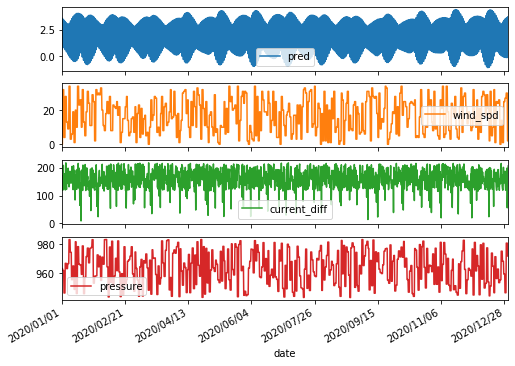

In [0]:
features.plot(subplots=True)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


TRAIN_SPLIT = 800



dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

past_history = 720
future_target = 72
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10


x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

#tf.reshape(x_train_single, [9600,4])
#tf.reshape(y_train_single, [80,1])
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('Single window of past history : {}'.format(y_train_single.shape))


train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=[120,4]))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')



Single window of past history : (120, 4)
Single window of past history : (80,)


In [0]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

In [0]:

print(train_data_single)
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

<RepeatDataset shapes: ((None, 120, 4), (None,)), types: (tf.float64, tf.float64)>
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 16s 78ms/step - loss: 0.7253


ValueError: ignored